In [23]:
import festim as F
import numpy as np
import matplotlib.pyplot as plt

Creating 2D mesh with FEniCS and mark its subdomains

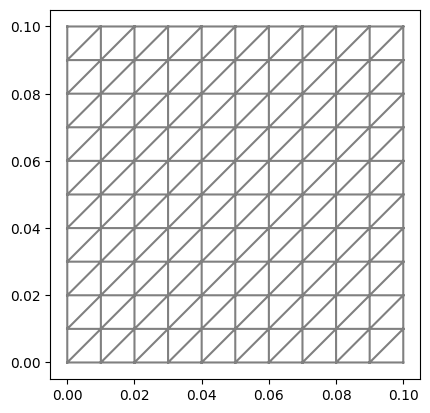

In [24]:
from fenics import Point, RectangleMesh, CompiledSubDomain, MeshFunction, plot

# creating a mesh with FEniCS
nx = ny = 10
# mesh_fenics = UnitSquareMesh(nx, ny)

mesh_fenics = RectangleMesh(Point(0.0, 0.0), Point(0.1, 0.1), nx, ny)

# marking physical groups (volumes and surfaces)
volume_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim())
volume_markers.set_all(1)

left_surface = CompiledSubDomain(
    'on_boundary && near(x[0], 0, tol)', tol=1e-14)
right_surface = CompiledSubDomain(
    'on_boundary && near(x[0], 0.1, tol)', tol=1e-14)
bottom_surface = CompiledSubDomain(
    'on_boundary && near(x[1], 0, tol)', tol=1e-14)
top_surface = CompiledSubDomain(
    'on_boundary && near(x[1], 0.1, tol)', tol=1e-14)

surface_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)
surface_markers.set_all(0)

# Surface ids
left_id = 1
top_id = 2
right_id = 3
bottom_id = 4
left_surface.mark(surface_markers, left_id)
right_surface.mark(surface_markers, right_id)
top_surface.mark(surface_markers, top_id)
bottom_surface.mark(surface_markers, bottom_id)

plot(mesh_fenics)


Helper Functions

In [ ]:
def read_results(export_path):
    """
    Takes in the path to the export file and returns the 
    """

In [25]:
def my_simulation(T_array, mesh_fenics):
    """
    Takes in a list of temperatures and a set mesh and returns a list of diffusion coefficients that correspond to each temperature
    """
    k_array = []
    for i in range(len(T_array)):
        # setting up current simulation
        model_2d = F.Simulation()

        # D, E_d source: "nakamura_hydrogen_2015"
        # Thermal cond source: https://dspace.mit.edu/bitstream/handle/1721.1/123988/Romatoski_SaltPropertyReview02.pdf?sequence=1&isAllowed=y#:~:text=From%20the%20data%20collected%2C%20the,an%20uncertainty%20of%20%C2%B110%25.
        mat = F.Material(
            id=1,
            D_0=1.508521565198744e-08,
            E_D=0.23690444592353738,
            thermal_cond=1.1
            )
        model_2d.materials = F.Materials([mat])

        # creating mesh with festim
        model_2d.mesh = F.Mesh(
            mesh=mesh_fenics,
            volume_markers=volume_markers,
            surface_markers=surface_markers
        )

        # setting up steady state heat transfer problem
        model_2d.T = F.HeatTransferProblem(transient=False)

        # dirichlet temperature boundary conditions
        T = T_array[i]

        heat_transfer_bcs = [
            F.DirichletBC(
                surfaces=[left_id],
                value=T,
                field="T"
            ),

            F.DirichletBC(
                surfaces=[right_id],
                value=T,
                field="T"
            ),
        ]

        # setting up T source
        model_2d.sources = [
            F.Source(
                value=1,
                volume=1,
                field=0
            )]
        
        # setting up tranpsport boundary conditions
        tritium_transport_bcs = [
            F.DirichletBC(
                surfaces=[1, 2, 3, 4], 
                value=0, 
                field=0
                )
        ]

        model_2d.boundary_conditions = heat_transfer_bcs + tritium_transport_bcs

        # setting up exports
        export_folder = "BABY_2D_results"

        derived_quantities = F.DerivedQuantities(filename=export_folder + "/simulation.csv")

        derived_quantities.derived_quantities = [
            F.SurfaceFlux(field="solute", surface=1),
            F.SurfaceFlux(field="solute", surface=2),
            F.SurfaceFlux(field="solute", surface=3),
            F.SurfaceFlux(field="solute", surface=4),
            F.AverageVolume(field="solute", volume=1)
            ]

        model_2d.exports = F.Exports([
            F.XDMFExport("solute", folder=export_folder),
            F.XDMFExport("retention", folder=export_folder),
            F.XDMFExport("T", folder=export_folder),
            derived_quantities
            ])
        
        # simulation parameters and running model
        model_2d.settings = F.Settings(
            transient=False,
            absolute_tolerance=1e-09,
            relative_tolerance=1e-09,
        )

        model_2d.initialise()
        model_2d.run()
        
        # reading results
        my_data = np.genfromtxt(export_folder + "/simulation.csv", names=True, delimiter=",")

        flux_1 = my_data["Flux_surface_1_solute"]
        flux_2 = my_data["Flux_surface_2_solute"]
        flux_3 = my_data["Flux_surface_3_solute"]
        flux_4 = my_data["Flux_surface_4_solute"]

        # calculating diffusion coefficient
        total_flux = abs(flux_1 + flux_2 + flux_3 + flux_4)

        average_conc = my_data["Average_solute_volume_1"]

        A = 0.4

        k = total_flux/(A*average_conc)

        k_array.append(k)
        

    return k_array

In [26]:
T_array = np.linspace(100, 1200, 12)

In [27]:
k_array = my_simulation(T_array, mesh_fenics)

Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s
Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s
Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s
Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s
Defining variational problem heat transfers
Solv

Text(0, 0.5, 'Transport Coefficient [m/s]')

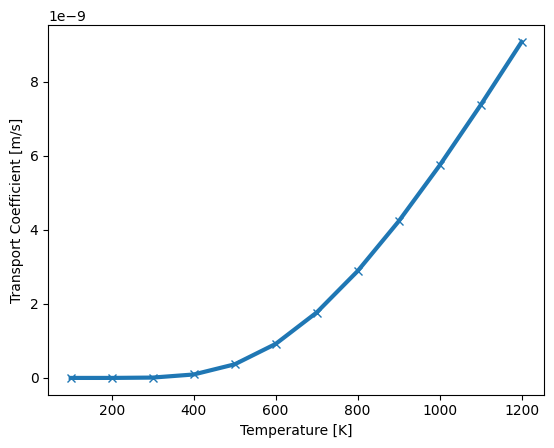

In [31]:
plt.plot(T_array, k_array, '-x', linewidth=3)
plt.xlabel("Temperature [K]")
plt.ylabel("Transport Coefficient [m/s]")